w2582743722
w1522301498
w1686810756
Total papers collected: 8145
Total edges collected: 15240


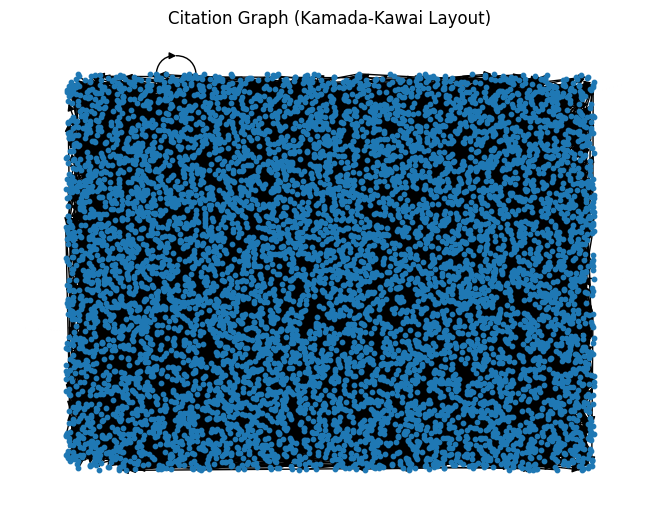

In [ ]:
#get articles from API
import requests
import csv
import networkx as nx
from typing import List, Set, Tuple, Optional
import matplotlib.pyplot as plt
import numpy as np

class Paper:
    _next_i = 0

    def __init__(self, id, title, authorships, abstract, topic, subfield, references, citations):
        self.i = Paper._next_i
        Paper._next_i += 1

        self.id = id
        self.title = title
        self.authorships = authorships
        self.abstract = abstract
        self.topic = topic
        self.subfield = subfield
        self.references = references or []
        self.citations = citations or []

    def to_dict(self):
        return {
            'i': self.i,
            'id': self.id,
            'title': self.title,
            'authorships': ', '.join(self.authorships),
            'abstract': self.abstract,
            'topic': self.topic,
            'subfield': self.subfield,
        }

def reconstruct_abstract(inverted_index):
    if not inverted_index:
        return ""
    indexed_words = [(pos, word) for word, positions in inverted_index.items() for pos in positions]
    indexed_words.sort()
    words = [word for _, word in indexed_words]
    if len(words)==0:
      return ""
    return ' '.join(words)

def fetch_paper_data(paper_id: str) -> Optional[dict]:
    if paper_id.startswith('https://openalex.org/'):
        paper_id = paper_id.split('/')[-1]
    url = f"https://api.openalex.org/works/{paper_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error fetching {paper_id}: {e}")
        return None

def scrape_citations(cited_by_api_url: str) -> List[str]:
    try:
        response = requests.get(cited_by_api_url)
        response.raise_for_status()
        data = response.json()
        # Return up to 10 citations' ids
        return [item['id'].split('/')[-1] for item in data.get('results', [])[:10]]
    except Exception as e:
        print(f"Error scraping citations: {e}")
        return []

def process_paper(paper_id: str, G: nx.DiGraph, seen_paper_ids: Set[str], depth: int, max_depth: int) -> Optional[Paper]:
    if paper_id in seen_paper_ids or depth > max_depth:
        return None

    data = fetch_paper_data(paper_id)
    if not data:
        return None

    id = data['id'].split('/')[-1]
    title = data.get('title', '')
    authorships = [a['author']['display_name'] for a in data.get('authorships', [])]
    abstract = reconstruct_abstract(data.get('abstract_inverted_index', {}))

    # Check abstract early before creating the Paper object or adding to graph
    if abstract=="":
        return None

    topic = (data.get('primary_topic') or {}).get('display_name', None)
    subfield = ((data.get('primary_topic') or {}).get('subfield') or {}).get('display_name', None)

    references = [ref.split('/')[-1] for ref in data.get('referenced_works', [])[:20]]
    citations = scrape_citations(data.get('cited_by_api_url', ''))[:20]

    paper = Paper(id, title, authorships, abstract, topic, subfield, references, citations)

    # Add paper node to graph with attributes
    G.add_node(paper.id, **paper.to_dict())
    seen_paper_ids.add(paper.id)

    # Add edges from paper to references
    for ref_id in references:
        G.add_edge(paper.id, ref_id)
    # Add edges from citations to paper
    for cit_id in citations:
        G.add_edge(cit_id, paper.id)

    # Recursive DFS on references and citations
    for neighbor_id in references + citations:
        process_paper(neighbor_id, G, seen_paper_ids, depth + 1, max_depth)

    return paper

def save_graph_to_csv(G: nx.DiGraph):
    # Save nodes
    with open('papers.csv', 'w', newline='', encoding='utf-8') as csvfile:
        fieldnames = ['id', 'title', 'authorships', 'abstract', 'topic', 'subfield']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for node, data in G.nodes(data=True):
            writer.writerow({
                'id': node,
                'title': data.get('title', ''),
                'authorships': data.get('authorships', ''),
                'abstract': data.get('abstract', ''),
                'topic': data.get('topic', ''),
                'subfield': data.get('subfield', ''),
            })

    # Save edges
    with open('edges.csv', 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['source', 'target'])
        for source, target in G.edges():
            writer.writerow([source, target])

def main():
    start_paper_id = 'W2134967712'  # change to your starting paper
    max_depth = 1  # how deep you want to go

    G = nx.DiGraph()
    seen_paper_ids = set()

    process_paper(start_paper_id, G, seen_paper_ids, depth=0, max_depth=max_depth)

    print(f"Total papers collected: {len(G.nodes)}")
    print(f"Total edges collected: {len(G.edges)}")

    save_graph_to_csv(G)

    pos = nx.random_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=10, arrows=True)
    plt.title("Citation Graph (Kamada-Kawai Layout)")
    plt.show()


if __name__ == "__main__":
    start_paper_ids = ['w2582743722', 'w1522301498', 'w1686810756']  # Add as many paper IDs as needed
    max_depth = 2  # how deep you want to go

    G = nx.DiGraph()
    seen_paper_ids = set()

    for start_paper_id in start_paper_ids:
        print(start_paper_id)
        process_paper(start_paper_id, G, seen_paper_ids, depth=0, max_depth=max_depth)


    print(f"Total papers collected: {len(G.nodes)}")
    print(f"Total edges collected: {len(G.edges)}")

    save_graph_to_csv(G)

    pos = nx.random_layout(G)
    nx.draw(G, pos, with_labels=False, node_size=10, arrows=True)
    plt.title("Citation Graph (Kamada-Kawai Layout)")
    plt.show()


In [1]:
!pip install torch_geometric
!pip install -q torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 146.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.8 MB/s eta 0:00:00


In [42]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling

# 1. Load data
df = pd.read_csv('papers.csv')
de = pd.read_csv('edges.csv')

print(df.columns)
print(de.columns)

Index(['Unnamed: 0.1', 'id', 'title', 'authorships', 'abstract', 'topic',
       'subfield', 'Unnamed: 0'],
      dtype='object')
Index(['Unnamed: 0.1', 'source', 'target', 'Unnamed: 0'], dtype='object')


In [43]:
# preprocessing

# Step 1: Get list of IDs with null abstracts
null_ids = df[df['abstract'].isnull()]['id']

# Step 2: Filter 'de' to exclude rows with any null-related node
de = de[~de['source'].isin(null_ids) & ~de['target'].isin(null_ids)]

# Step 3: Remove null rows from 'df'
df = df[~df['id'].isin(null_ids)]


In [ ]:
df.to_csv("papers.csv")
de.to_csv('edges.csv')

In [44]:

# 2. Encode node IDs as integers for PyG
node_encoder = LabelEncoder()
all_nodes = list(set(de['source']).union(set(de['target'])))
node_encoder.fit(all_nodes)

source = node_encoder.transform(de['source'])
target = node_encoder.transform(de['target'])
edge_index = torch.tensor(np.vstack([source, target]), dtype=torch.long)

num_nodes = len(node_encoder.classes_)

In [45]:

# 3. Extract TF-IDF features from abstracts
texts = df['abstract'].fillna('')
vectorizer = TfidfVectorizer(max_features=300)
tfidf_features = vectorizer.fit_transform(texts).toarray()

id_to_index = {pid: idx for idx, pid in enumerate(df['id'])}

features = []
for node_id in node_encoder.classes_:
    idx = id_to_index.get(node_id)
    if idx is not None:
        features.append(tfidf_features[idx])
    else:
        features.append(np.zeros(tfidf_features.shape[1]))
features = np.array(features)

x = torch.tensor(features, dtype=torch.float)


# 4. Create PyG data object
data = Data(x=x, edge_index=edge_index)

# 5. Split edges into train/val/test using RandomLinkSplit
transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=False,
    split_labels=True,
    add_negative_train_samples=True,
)
train_data, val_data, test_data = transform(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 7. Define Link Predictor (MLP)
class LinkPredictor(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.lin1 = torch.nn.Linear(emb_dim * 2, 64)
        self.lin2 = torch.nn.Linear(64, 1)

    def forward(self, z, edge_index):
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        x = torch.cat([src, dst], dim=1)
        x = F.relu(self.lin1(x))
        x = torch.sigmoid(self.lin2(x)).squeeze()
        return x


In [6]:


# 6. Define GCN Encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x



model = GCNEncoder(in_channels=x.size(1), hidden_channels=64, out_channels=32).to(device)



Epoch 000 | Loss: 0.6952 | Val Acc: 0.5000 | Test Acc: 0.5000
Epoch 010 | Loss: 0.5772 | Val Acc: 0.6858 | Test Acc: 0.6925
Epoch 020 | Loss: 0.4799 | Val Acc: 0.7389 | Test Acc: 0.7212
Epoch 030 | Loss: 0.3896 | Val Acc: 0.7566 | Test Acc: 0.7412
Epoch 040 | Loss: 0.3386 | Val Acc: 0.7942 | Test Acc: 0.7677
Epoch 050 | Loss: 0.2918 | Val Acc: 0.7810 | Test Acc: 0.7876
Epoch 060 | Loss: 0.2558 | Val Acc: 0.7920 | Test Acc: 0.7920
Epoch 070 | Loss: 0.2257 | Val Acc: 0.7942 | Test Acc: 0.7854
Epoch 080 | Loss: 0.2000 | Val Acc: 0.8075 | Test Acc: 0.8031
Epoch 090 | Loss: 0.1824 | Val Acc: 0.7898 | Test Acc: 0.7566
Epoch 099 | Loss: 0.1747 | Val Acc: 0.8031 | Test Acc: 0.7854


In [39]:
from torch_geometric.nn import GATConv
# GAT-based encoder
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        # Note: output dim = hidden_channels * heads
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return x
model = GCNEncoder(in_channels=x.size(1), hidden_channels=64, out_channels=32).to(device)



In [33]:
from torch_geometric.nn import SAGEConv
# GraphSAGE-based encoder
class SAGEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.sage1 = SAGEConv(in_channels, hidden_channels)
        self.sage2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = self.sage2(x, edge_index)
        return x
model = SAGEEncoder(in_channels=x.size(1), hidden_channels=64, out_channels=32).to(device)


In [40]:
predictor = LinkPredictor(emb_dim=32).to(device)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

optimizer = torch.optim.Adam(list(model.parameters()) + list(predictor.parameters()), lr=0.01)
epochs = 100

def train():
    model.train()
    predictor.train()
    optimizer.zero_grad()

    # Use training graph edges for GCN
    z = model(train_data.x, train_data.edge_index)

    # Positive and negative edges for training
    pos_edge_index = train_data.pos_edge_label_index
    neg_edge_index = train_data.neg_edge_label_index

    # If no negatives in train split (sometimes can happen), sample manually
    if neg_edge_index is None or neg_edge_index.size(1) == 0:
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index,
            num_nodes=train_data.num_nodes,
            num_neg_samples=pos_edge_index.size(1),
        )

    pos_pred = predictor(z, pos_edge_index)
    neg_pred = predictor(z, neg_edge_index)

    pos_labels = torch.ones(pos_pred.size(0), device=device)
    neg_labels = torch.zeros(neg_pred.size(0), device=device)

    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    loss = F.binary_cross_entropy(preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    predictor.eval()

    z = model(data.x, data.edge_index)

    pos_pred = predictor(z, data.pos_edge_label_index)
    neg_pred = predictor(z, data.neg_edge_label_index)

    pos_labels = torch.ones(pos_pred.size(0), device=device)
    neg_labels = torch.zeros(neg_pred.size(0), device=device)

    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    pred_labels = (preds > 0.5).float()
    accuracy = (pred_labels == labels).sum().item() / labels.size(0)
    return accuracy

for epoch in range(epochs):
    loss = train()
    if epoch % 10 == 0 or epoch == epochs - 1:
        val_acc = test(val_data)
        test_acc = test(test_data)
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch 000 | Loss: 0.6908 | Val Acc: 0.5000 | Test Acc: 0.5000
Epoch 010 | Loss: 0.5807 | Val Acc: 0.7058 | Test Acc: 0.7257
Epoch 020 | Loss: 0.4791 | Val Acc: 0.7389 | Test Acc: 0.7898
Epoch 030 | Loss: 0.3856 | Val Acc: 0.7456 | Test Acc: 0.8208
Epoch 040 | Loss: 0.3205 | Val Acc: 0.7743 | Test Acc: 0.8274
Epoch 050 | Loss: 0.2662 | Val Acc: 0.7677 | Test Acc: 0.8341
Epoch 060 | Loss: 0.2346 | Val Acc: 0.7699 | Test Acc: 0.8473
Epoch 070 | Loss: 0.2042 | Val Acc: 0.7920 | Test Acc: 0.8584
Epoch 080 | Loss: 0.1866 | Val Acc: 0.7743 | Test Acc: 0.8319
Epoch 090 | Loss: 0.1614 | Val Acc: 0.8031 | Test Acc: 0.8407
Epoch 099 | Loss: 0.1443 | Val Acc: 0.7942 | Test Acc: 0.8208


In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

@torch.no_grad()
def test_with_roc(data):
    model.eval()
    predictor.eval()

    z = model(data.x, data.edge_index)

    pos_pred = predictor(z, data.pos_edge_label_index).cpu()
    neg_pred = predictor(z, data.neg_edge_label_index).cpu()

    pos_labels = torch.ones(pos_pred.size(0))
    neg_labels = torch.zeros(neg_pred.size(0))

    preds = torch.cat([pos_pred, neg_pred], dim=0).numpy()
    labels = torch.cat([pos_labels, neg_labels], dim=0).numpy()

    # ROC curve
    fpr, tpr, _ = roc_curve(labels, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Link Prediction')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


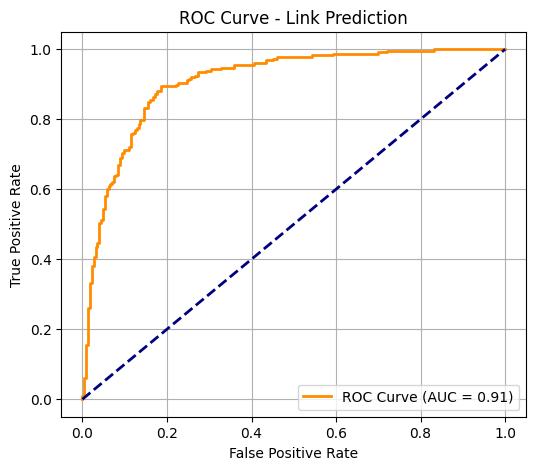

In [41]:
test_with_roc(test_data)


Epoch 000 | Loss: 0.9062 | Val Acc: 0.5000 | Test Acc: 0.5000
Epoch 010 | Loss: 0.6724 | Val Acc: 0.5155 | Test Acc: 0.5310
Epoch 020 | Loss: 0.6018 | Val Acc: 0.6770 | Test Acc: 0.6128
Epoch 030 | Loss: 0.5722 | Val Acc: 0.6836 | Test Acc: 0.6239
Epoch 040 | Loss: 0.5616 | Val Acc: 0.6925 | Test Acc: 0.6504
Epoch 050 | Loss: 0.5544 | Val Acc: 0.6925 | Test Acc: 0.6482
Epoch 060 | Loss: 0.5486 | Val Acc: 0.6991 | Test Acc: 0.6571
Epoch 070 | Loss: 0.5427 | Val Acc: 0.6969 | Test Acc: 0.6726
Epoch 080 | Loss: 0.5370 | Val Acc: 0.6991 | Test Acc: 0.6659
Epoch 090 | Loss: 0.5321 | Val Acc: 0.6969 | Test Acc: 0.6681
Epoch 099 | Loss: 0.5276 | Val Acc: 0.7146 | Test Acc: 0.6637


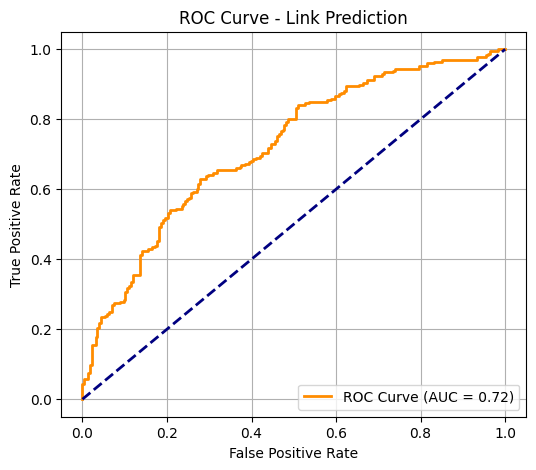

In [24]:
test_with_roc(test_data)


In [ ]:


def train():
    model.train()
    predictor.train()
    optimizer.zero_grad()

    # Use training graph edges for GCN
    z = model(train_data.x, train_data.edge_index)

    # Positive and negative edges for training
    pos_edge_index = train_data.pos_edge_label_index
    neg_edge_index = train_data.neg_edge_label_index

    # If no negatives in train split (sometimes can happen), sample manually
    if neg_edge_index is None or neg_edge_index.size(1) == 0:
        neg_edge_index = negative_sampling(
            edge_index=train_data.edge_index,
            num_nodes=train_data.num_nodes,
            num_neg_samples=pos_edge_index.size(1),
        )

    pos_pred = predictor(z, pos_edge_index)
    neg_pred = predictor(z, neg_edge_index)

    pos_labels = torch.ones(pos_pred.size(0), device=device)
    neg_labels = torch.zeros(neg_pred.size(0), device=device)

    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    loss = F.binary_cross_entropy(preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    predictor.eval()

    z = model(data.x, data.edge_index)

    pos_pred = predictor(z, data.pos_edge_label_index)
    neg_pred = predictor(z, data.neg_edge_label_index)

    pos_labels = torch.ones(pos_pred.size(0), device=device)
    neg_labels = torch.zeros(neg_pred.size(0), device=device)

    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    pred_labels = (preds > 0.5).float()
    accuracy = (pred_labels == labels).sum().item() / labels.size(0)
    return accuracy

for epoch in range(epochs):
    loss = train()
    if epoch % 10 == 0 or epoch == epochs - 1:
        val_acc = test(val_data)
        test_acc = test(test_data)
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")

In [7]:
#testing

import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data

# 1. Load new papers and edges
new_df = pd.read_csv('papers.csv')
new_de = pd.read_csv('edges.csv')

# 2. Encode node IDs using the **same label encoder** from training
# Warning: if new nodes weren't in training data, they’ll be skipped

valid_edges = []
source_indices = []
target_indices = []

for src, tgt in zip(new_de['source'], new_de['target']):
    if src in node_encoder.classes_ and tgt in node_encoder.classes_:
        source_indices.append(node_encoder.transform([src])[0])
        target_indices.append(node_encoder.transform([tgt])[0])
        valid_edges.append((src, tgt))

if len(valid_edges) == 0:
    raise ValueError("None of the new edges contain known nodes from training!")

edge_index_new = torch.tensor([source_indices, target_indices], dtype=torch.long).to(device)

# 3. Get features for each node using the same TF-IDF vectorizer
new_df['abstract'] = new_df['abstract'].fillna('')
id_to_index_new = {pid: idx for idx, pid in enumerate(new_df['id'])}

features_new = []
for node_id in node_encoder.classes_:
    if node_id in id_to_index_new:
        text = new_df.loc[id_to_index_new[node_id], 'abstract']
        vec = vectorizer.transform([text]).toarray()[0]
        features_new.append(vec)
    else:
        features_new.append(np.zeros(vectorizer.max_features))

x_new = torch.tensor(np.array(features_new), dtype=torch.float).to(device)

# 4. Build graph and get embeddings
data_new = Data(x=x_new, edge_index=edge_index_new).to(device)

model.eval()
predictor.eval()
with torch.no_grad():
    z = model(data_new.x, data.edge_index)  # NOTE: use original training edges here!

    scores = predictor(z, edge_index_new)

# 5. Show results
print("🔗 Predicted Link Probabilities (using trained model):\n")
for (src, tgt), score in zip(valid_edges, scores.cpu().numpy()):
    print(f"{src} <-> {tgt}: {score:.4f}")


🔗 Predicted Link Probabilities (using trained model):

W1959608418 <-> W177847060: 0.8132
W1959608418 <-> W2080829915: 0.9435
W1959608418 <-> W2097268041: 0.9796
W1959608418 <-> W2103633133: 0.5263
W1959608418 <-> W2119196781: 0.9493
W1959608418 <-> W2135346645: 0.9589
W1959608418 <-> W2145094598: 0.8966
W1959608418 <-> W2163922914: 0.9621
W1959608418 <-> W2166851633: 0.9797
W1959608418 <-> W2171490498: 0.9107
W1959608418 <-> W2405601855: 0.7142
W1959608418 <-> W2951493172: 0.9939
W1959608418 <-> W2963173382: 0.7314
W1959608418 <-> W3104819538: 0.8832
W177847060 <-> W151672344: 0.8875
W177847060 <-> W189596042: 0.9940
W177847060 <-> W1993845689: 0.9957
W177847060 <-> W2072128103: 0.9946
W177847060 <-> W2096192494: 0.9903
W177847060 <-> W2122565151: 0.8125
W177847060 <-> W2130325614: 0.9928
W177847060 <-> W2134557905: 0.9691
W177847060 <-> W2136922672: 0.9995
W177847060 <-> W2154956324: 0.7325
W177847060 <-> W2157629899: 0.9291
W177847060 <-> W2161893161: 0.8438
W177847060 <-> W21721746